# Exploration du Dataset Online Retail II

Ce notebook explore le dataset Online Retail II pour comprendre les transactions e-commerce et préparer les analyses de segmentation client (RFM, CLV).

**Dataset**: Transactions e-commerce (~500k lignes)
**Objectif**: Exploration initiale, nettoyage et visualisations clés
# Fiche synthétique du dataset

**Source :** UCI Machine Learning Repository – Online Retail II  
**Nature :** Transactions e-commerce d’un détaillant UK  
**Période couverte :** Décembre 2009 → Décembre 2011  
**Granularité :** ligne de facture (Invoice × produit)

**Volumes :**
- ~1 067 000 transactions brutes
- 8 variables principales
- Niveau : e-commerce B2C/B2B

**Colonnes clés :**
- `Invoice` - Identifiant facture (Cxxxx = retour)
- `InvoiceDate` - Date de transaction
- `CustomerID` - Identifiant client
- `Quantity` - Quantité (négative = retour)
- `Price` - Prix unitaire
- `Revenue` - Montant de la ligne
- `Country` - Pays du client

Cette fiche permet d’encadrer l’analyse exploratoire.


## 1. Chargement des librairies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Affichage complet des colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Chargement des données

# Dictionnaire des variables

| Variable      | Type      | Description                                           | Unités |
|---------------|-----------|-------------------------------------------------------|--------|
| Invoice       | string    | Identifiant de facture. `Cxxxx = crédit/retour`       | -      |
| StockCode     | string    | Code produit                                          | -      |
| Description   | string    | Nom du produit                                        | -      |
| Quantity      | int       | Quantité (valeurs négatives = retours)                | unités |
| Price         | float     | Prix unitaire                                         | GBP    |
| InvoiceDate   | datetime  | Date et heure de la transaction                       | -      |
| CustomerID    | float/int | Identifiant client unique                             | -      |
| Country       | string    | Pays du client                                        | -      |


In [ ]:
# Chemin vers le fichier Excel
data_path = r"/Users/maximedutertre/Desktop/Ecole/ECE/4eme annee/data-visualisation/projet_final/data/raw/online_retail_II.xlsx"
# Chargement du fichier Excel (peut prendre quelques secondes)
print("Chargement des données en cours...")
df_raw = pd.read_excel(data_path)

print(f"Données chargées: {df_raw.shape[0]:,} lignes et {df_raw.shape[1]} colonnes")
print(f"Période: {df_raw['InvoiceDate'].min()} à {df_raw['InvoiceDate'].max()}")

Chargement des données en cours...
Données chargées: 525,461 lignes et 8 colonnes
Période: 2009-12-01 07:45:00 à 2010-12-09 20:01:00


## 3. Aperçu initial des données

In [14]:
# Premières lignes
df_raw.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [15]:
# Informations sur les colonnes et types de données
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [16]:
# Statistiques descriptives
df_raw.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


## 4. Qualité des données - Valeurs manquantes

In [17]:
# Analyse des valeurs manquantes
missing_data = pd.DataFrame({
    'Colonnes': df_raw.columns,
    'Valeurs manquantes': df_raw.isnull().sum(),
    'Pourcentage': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
}).sort_values('Valeurs manquantes', ascending=False)

print("Valeurs manquantes par colonne:")
print(missing_data[missing_data['Valeurs manquantes'] > 0])

Valeurs manquantes par colonne:
                Colonnes  Valeurs manquantes  Pourcentage
Customer ID  Customer ID              107927        20.54
Description  Description                2928         0.56


## 5. Nettoyage des données

Nous allons documenter chaque étape de nettoyage et le nombre de lignes perdues.

In [29]:
# ============================================================
# 🔧 NETTOYAGE DU DATASET (version corrigée)
# ============================================================

df = df_raw.copy()

print(f"Lignes initiales : {len(df):,}")
print("="*60)

# ------------------------------------------------------------
# 1. Suppression Customer ID manquants
# ------------------------------------------------------------
rows_before = len(df)
df = df[df['Customer ID'].notna()]
rows_lost = rows_before - len(df)

print(f"Étape 1 - Suppression Customer ID manquants : -{rows_lost:,} lignes")
print(f"Lignes restantes : {len(df):,}\n")

# ------------------------------------------------------------
# 2. Suppression Description manquante
# ------------------------------------------------------------
rows_before = len(df)
df = df[df['Description'].notna()]
rows_lost = rows_before - len(df)

print(f"Étape 2 - Suppression Description manquantes : -{rows_lost:,} lignes")
print(f"Lignes restantes : {len(df):,}\n")

# ------------------------------------------------------------
# 3. Marquage des retours (NE PAS les supprimer ❗)
# ------------------------------------------------------------
df["Invoice"] = df["Invoice"].astype(str)
df["is_return"] = (df["Quantity"] < 0) | (df["Invoice"].str.startswith("C"))

print(f"Étape 3 - Retours détectés : {df['is_return'].sum():,} lignes")
print(f"Part des retours : {df['is_return'].mean():.2%}\n")

# ------------------------------------------------------------
# 4. Suppression prix invalides
# ------------------------------------------------------------
rows_before = len(df)
df = df[df['Price'] > 0]
rows_lost = rows_before - len(df)

print(f"Étape 4 - Suppression Price <= 0 : -{rows_lost:,} lignes")
print(f"Lignes restantes : {len(df):,}\n")

# ------------------------------------------------------------
# 5. Calcul du revenu par ligne
# ------------------------------------------------------------
df['Revenue'] = df['Quantity'] * df['Price']

print("Étape 5 - Revenue calculé.")
print(f"Revenue total brut : £{df['Revenue'].sum():,.2f}\n")

# ------------------------------------------------------------
# 🔚 Résumé
# ------------------------------------------------------------
print("="*60)
print(" RÉSUMÉ FINAL DU NETTOYAGE (version correcte)")
total_lost = len(df_raw) - len(df)
print(f"Lignes initiales : {len(df_raw):,}")
print(f"Lignes finales   : {len(df):,}")
print(f"Lignes supprimées : {total_lost:,} ({total_lost/len(df_raw)*100:.2f}%)")
print(f"Retours détectés (présents dans df) : {df['is_return'].sum():,}")
print("="*60)


Lignes initiales : 525,461
Étape 1 - Suppression Customer ID manquants : -107,927 lignes
Lignes restantes : 417,534

Étape 2 - Suppression Description manquantes : -0 lignes
Lignes restantes : 417,534

Étape 3 - Retours détectés : 9,839 lignes
Part des retours : 2.36%

Étape 4 - Suppression Price <= 0 : -31 lignes
Lignes restantes : 417,503

Étape 5 - Revenue calculé.
Revenue total brut : £8,348,208.57

 RÉSUMÉ FINAL DU NETTOYAGE (version correcte)
Lignes initiales : 525,461
Lignes finales   : 417,503
Lignes supprimées : 107,958 (20.55%)
Retours détectés (présents dans df) : 9,839


Nombre de retours : 9839
Part des retours : 0.023566297727201962
Impact financier total des retours : -483794.69999999995


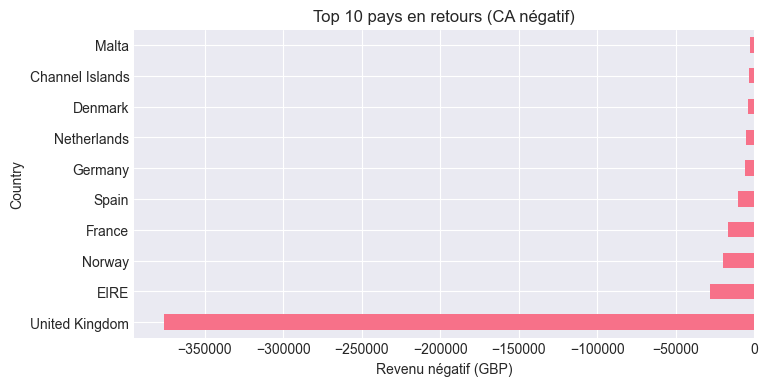

In [30]:
# Analyse des retours (Quantity < 0 OU Invoice commençant par "C")
df['is_return'] = (df['Quantity'] < 0) | df['Invoice'].astype(str).str.startswith('C')

print("Nombre de retours :", df['is_return'].sum())
print("Part des retours :", df['is_return'].mean())

# Montant négatif total des retours
returns_ca = df.loc[df['is_return'], 'Revenue'].sum()
print("Impact financier total des retours :", returns_ca)

# Top pays responsables des retours
returns_by_country = (
    df[df['is_return']]
    .groupby('Country')['Revenue']
    .sum()
    .sort_values()
    .head(10)
)

returns_by_country.plot(kind='barh', figsize=(8,4), title="Top 10 pays en retours (CA négatif)")
plt.xlabel("Revenu négatif (GBP)")
plt.show()


### Interprétation - Analyse des retours

Les retours représentent une part importante des transactions e-commerce et doivent être analysés séparément car :

- **9 839 retours détectés** dans le dataset (≈ **2.36 %** des lignes après nettoyage).
- Leur impact financier total est de **– £483 794,70**, ce qui réduit fortement le revenu net.
- Les retours apparaissent sous la forme :
  - de **quantités négatives** (`Quantity < 0`)
  - ou de **factures annulées** (`Invoice` commençant par "C")

**Pourquoi c’est important pour la suite :**
- Les retours influencent directement la marge et le CLV.
- Ils varient fortement selon les pays et les produits.
- L’application Streamlit devra permettre de **filtrer** :
  - inclure les retours,
  - exclure les retours,
  - neutraliser (mettre Revenue = 0).

Une bonne compréhension des retours est essentielle pour toutes les analyses marketing (cohortes, RFM, CLV…).


## 6. Statistiques générales après nettoyage

In [19]:
print("STATISTIQUES GENERALES")
print("="*60)
print(f"Période: {df['InvoiceDate'].min().date()} à {df['InvoiceDate'].max().date()}")
print(f"Nombre de transactions: {df['Invoice'].nunique():,}")
print(f"Nombre de clients uniques: {df['Customer ID'].nunique():,}")
print(f"Nombre de produits uniques: {df['StockCode'].nunique():,}")
print(f"Nombre de pays: {df['Country'].nunique()}")
print()
print(f"Revenu total: £{df['Revenue'].sum():,.2f}")
print(f"Revenu moyen par transaction: £{df.groupby('Invoice')['Revenue'].sum().mean():,.2f}")
print(f"Panier moyen (articles): {df.groupby('Invoice')['Quantity'].sum().mean():.2f}")

STATISTIQUES GENERALES
Période: 2009-12-01 à 2010-12-09
Nombre de transactions: 19,213
Nombre de clients uniques: 4,312
Nombre de produits uniques: 4,017
Nombre de pays: 37

Revenu total: £8,832,003.27
Revenu moyen par transaction: £459.69
Panier moyen (articles): 288.26


## 7. Visualisation 1: Revenu au fil du temps

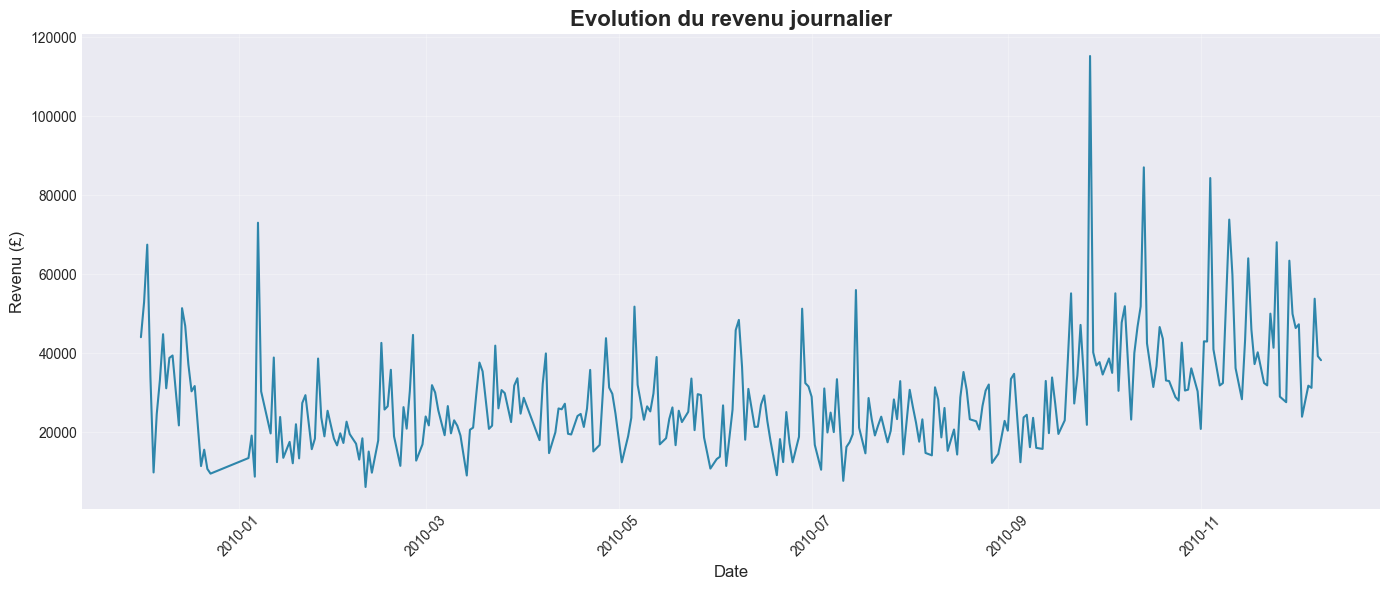

Revenu journalier moyen: £28,768.74
Jour avec le plus haut revenu: 2010-09-27 (£115,243.44)


In [20]:
# Agrégation du revenu par jour
df['Date'] = df['InvoiceDate'].dt.date
daily_revenue = df.groupby('Date')['Revenue'].sum().reset_index()

# Graphique
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_revenue['Date'], daily_revenue['Revenue'], linewidth=1.5, color='#2E86AB')
ax.set_title('Evolution du revenu journalier', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Revenu (£)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Revenu journalier moyen: £{daily_revenue['Revenue'].mean():,.2f}")
print(f"Jour avec le plus haut revenu: {daily_revenue.loc[daily_revenue['Revenue'].idxmax(), 'Date']} (£{daily_revenue['Revenue'].max():,.2f})")

## 8. Visualisation 2: Top 10 pays par revenu

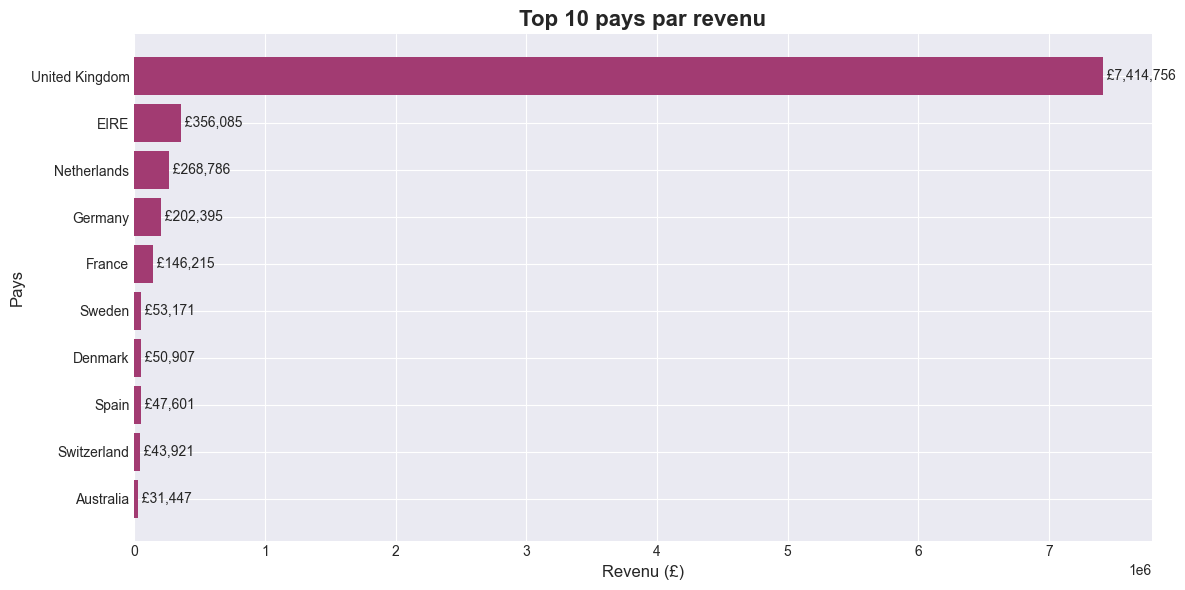


Détails des top 10 pays:
                     Revenu  Clients  Transactions
Country                                           
United Kingdom  7414755.963     3969         17612
EIRE             356085.210        5           316
Netherlands      268786.000       22           135
Germany          202395.321       67           347
France           146215.420       47           236
Sweden            53171.390       16            68
Denmark           50906.850        9            26
Spain             47601.420       25            66
Switzerland       43921.390       14            40
Australia         31446.800       15            40


In [21]:
# Top 10 pays
country_revenue = df.groupby('Country').agg({
    'Revenue': 'sum',
    'Customer ID': 'nunique',
    'Invoice': 'nunique'
}).sort_values('Revenue', ascending=False).head(10)

country_revenue.columns = ['Revenu', 'Clients', 'Transactions']

# Graphique
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(country_revenue.index, country_revenue['Revenu'], color='#A23B72')
ax.set_title('Top 10 pays par revenu', fontsize=16, fontweight='bold')
ax.set_xlabel('Revenu (£)', fontsize=12)
ax.set_ylabel('Pays', fontsize=12)
ax.invert_yaxis()

# Annotations
for i, (idx, row) in enumerate(country_revenue.iterrows()):
    ax.text(row['Revenu'], i, f" £{row['Revenu']:,.0f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Tableau détaillé
print("\nDétails des top 10 pays:")
print(country_revenue.to_string())

## 9. Visualisation 3: Analyse des produits

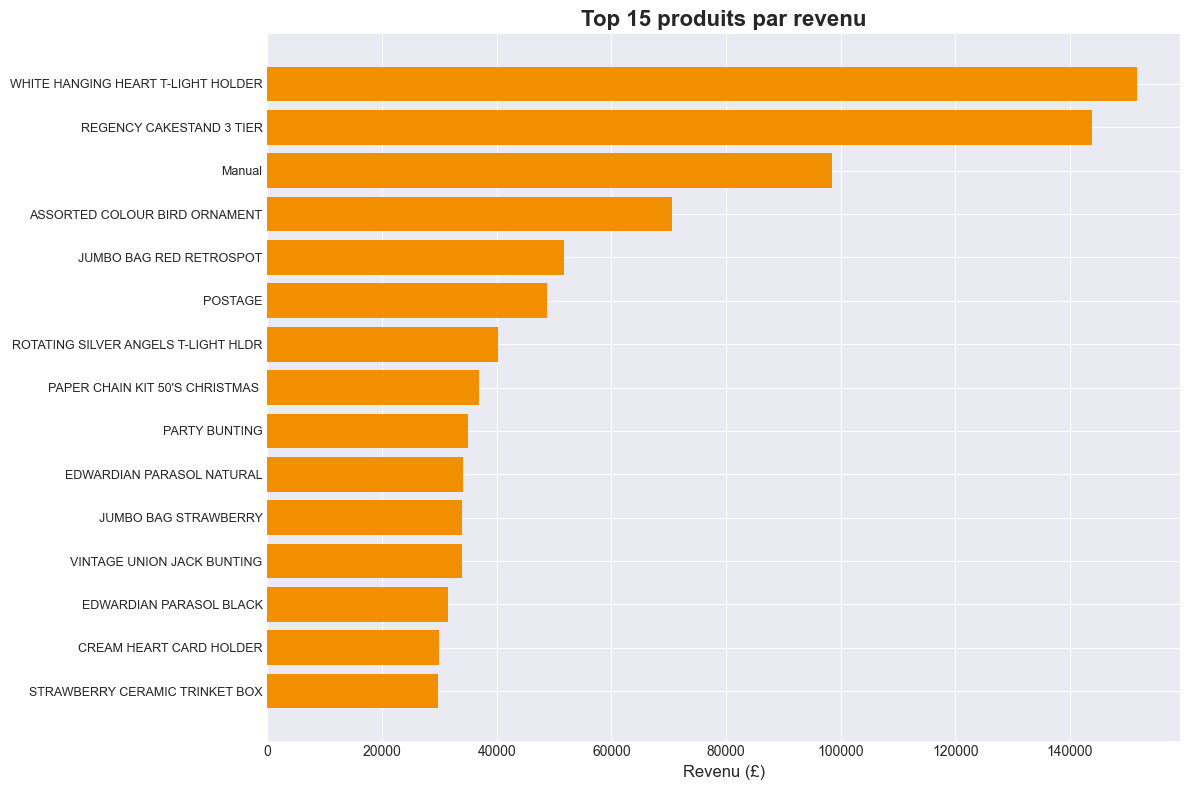


Top 5 produits détaillés:
                                                 Revenu  Quantité vendue  Nombre de commandes
StockCode Description                                                                        
85123A    WHITE HANGING HEART T-LIGHT HOLDER  151624.31            56915                 3021
22423     REGENCY CAKESTAND 3 TIER            143893.35            12497                 1687
M         Manual                               98560.64             2630                  382
84879     ASSORTED COLOUR BIRD ORNAMENT        70493.83            44551                 1333
85099B    JUMBO BAG RED RETROSPOT              51759.30            29578                 1060


In [22]:
# Top 15 produits par revenu
product_revenue = df.groupby(['StockCode', 'Description']).agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'Invoice': 'nunique'
}).sort_values('Revenue', ascending=False).head(15)

product_revenue.columns = ['Revenu', 'Quantité vendue', 'Nombre de commandes']

# Graphique
fig, ax = plt.subplots(figsize=(12, 8))
y_pos = range(len(product_revenue))
bars = ax.barh(y_pos, product_revenue['Revenu'], color='#F18F01')

# Labels courts pour les produits
labels = [desc[:40] + '...' if len(desc) > 40 else desc for desc in product_revenue.index.get_level_values('Description')]
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_title('Top 15 produits par revenu', fontsize=16, fontweight='bold')
ax.set_xlabel('Revenu (£)', fontsize=12)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 produits détaillés:")
print(product_revenue.head().to_string())

## 10. Visualisation 4: Distribution des clients

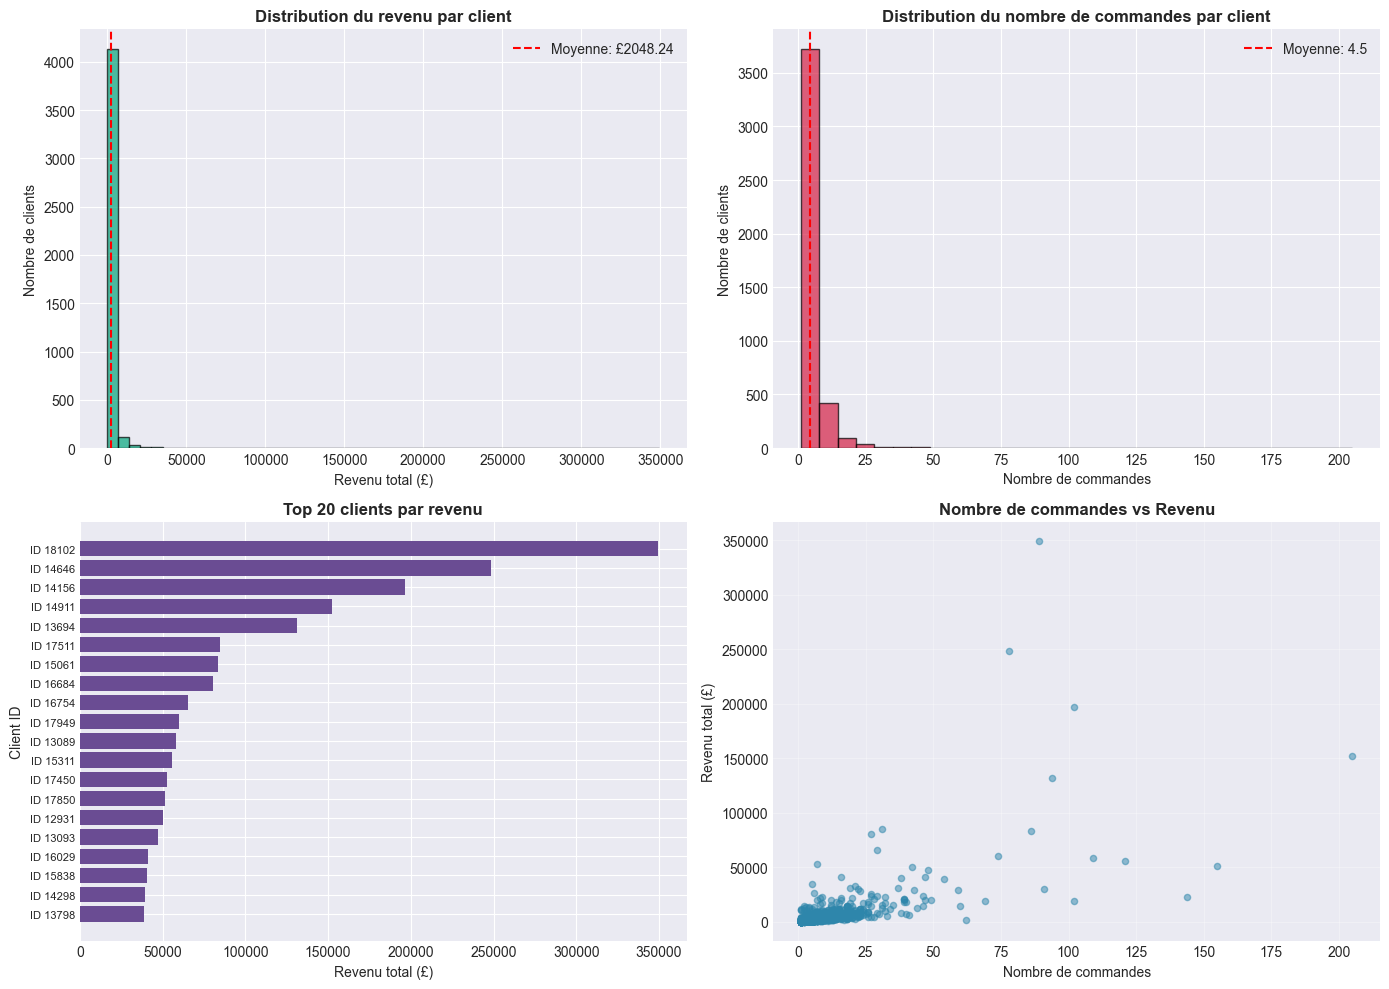

STATISTIQUES CLIENTS
Nombre total de clients: 4,312
Revenu moyen par client: £2,048.24
Revenu médian par client: £706.02
Commandes moyennes par client: 4.46
Articles moyens par client: 1284.40

Top 5 clients:
             Revenu total  Nombre de commandes  Articles achetés
Customer ID                                                     
18102.0         349164.35                   89            124216
14646.0         248396.50                   78            170278
14156.0         196566.74                  102            108107
14911.0         152147.57                  205             69722
13694.0         131443.19                   94            125893


In [23]:
# Analyse par client
customer_stats = df.groupby('Customer ID').agg({
    'Revenue': 'sum',
    'Invoice': 'nunique',
    'Quantity': 'sum'
}).rename(columns={
    'Revenue': 'Revenu total',
    'Invoice': 'Nombre de commandes',
    'Quantity': 'Articles achetés'
})

# Graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution du revenu par client
axes[0, 0].hist(customer_stats['Revenu total'], bins=50, color='#06A77D', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution du revenu par client', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Revenu total (£)')
axes[0, 0].set_ylabel('Nombre de clients')
axes[0, 0].axvline(customer_stats['Revenu total'].mean(), color='red', linestyle='--', label=f"Moyenne: £{customer_stats['Revenu total'].mean():.2f}")
axes[0, 0].legend()

# 2. Distribution du nombre de commandes par client
axes[0, 1].hist(customer_stats['Nombre de commandes'], bins=30, color='#D62246', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution du nombre de commandes par client', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Nombre de commandes')
axes[0, 1].set_ylabel('Nombre de clients')
axes[0, 1].axvline(customer_stats['Nombre de commandes'].mean(), color='red', linestyle='--', label=f"Moyenne: {customer_stats['Nombre de commandes'].mean():.1f}")
axes[0, 1].legend()

# 3. Top 20 clients par revenu
top_customers = customer_stats.nlargest(20, 'Revenu total')
axes[1, 0].barh(range(len(top_customers)), top_customers['Revenu total'], color='#6A4C93')
axes[1, 0].set_title('Top 20 clients par revenu', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Revenu total (£)')
axes[1, 0].set_ylabel('Client ID')
axes[1, 0].set_yticks(range(len(top_customers)))
axes[1, 0].set_yticklabels([f"ID {int(cid)}" for cid in top_customers.index], fontsize=8)
axes[1, 0].invert_yaxis()

# 4. Relation commandes vs revenu
axes[1, 1].scatter(customer_stats['Nombre de commandes'], customer_stats['Revenu total'], 
                   alpha=0.5, color='#2E86AB', s=20)
axes[1, 1].set_title('Nombre de commandes vs Revenu', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Nombre de commandes')
axes[1, 1].set_ylabel('Revenu total (£)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques clients
print("STATISTIQUES CLIENTS")
print("="*60)
print(f"Nombre total de clients: {len(customer_stats):,}")
print(f"Revenu moyen par client: £{customer_stats['Revenu total'].mean():,.2f}")
print(f"Revenu médian par client: £{customer_stats['Revenu total'].median():,.2f}")
print(f"Commandes moyennes par client: {customer_stats['Nombre de commandes'].mean():.2f}")
print(f"Articles moyens par client: {customer_stats['Articles achetés'].mean():.2f}")
print()
print("Top 5 clients:")
print(customer_stats.nlargest(5, 'Revenu total').to_string())

## 11. Analyse temporelle

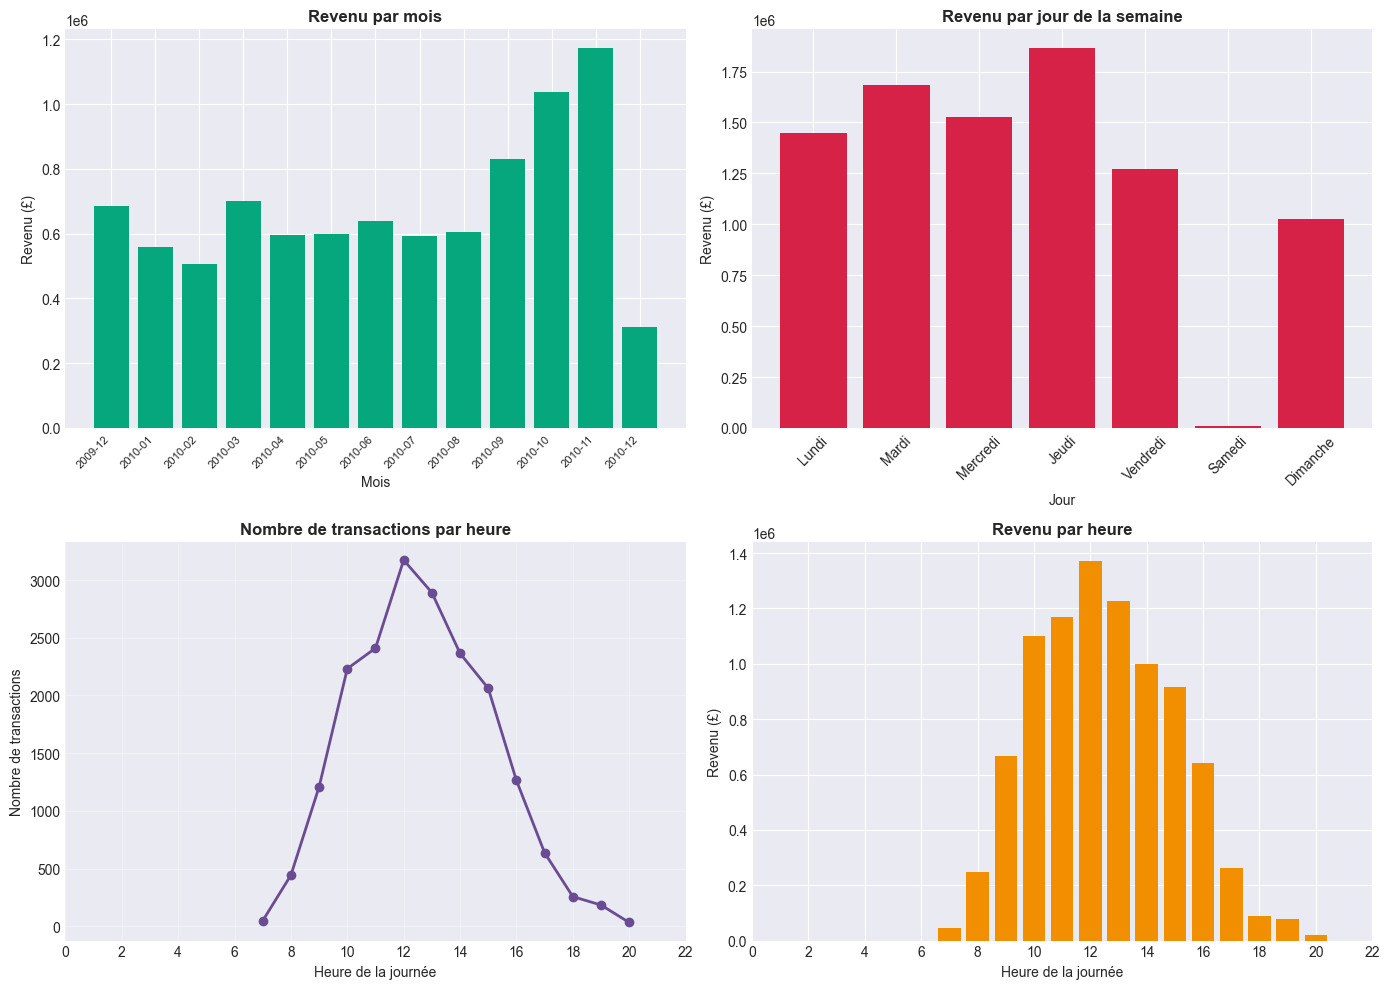

In [24]:
# Extraction des composantes temporelles
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Graphiques temporels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenu par mois
monthly_revenue = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
monthly_revenue['YearMonth'] = monthly_revenue['Year'].astype(str) + '-' + monthly_revenue['Month'].astype(str).str.zfill(2)
axes[0, 0].bar(range(len(monthly_revenue)), monthly_revenue['Revenue'], color='#06A77D')
axes[0, 0].set_title('Revenu par mois', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Mois')
axes[0, 0].set_ylabel('Revenu (£)')
axes[0, 0].set_xticks(range(len(monthly_revenue)))
axes[0, 0].set_xticklabels(monthly_revenue['YearMonth'], rotation=45, ha='right', fontsize=8)

# 2. Revenu par jour de la semaine
dow_revenue = df.groupby('DayOfWeek')['Revenue'].sum()
dow_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
axes[0, 1].bar(dow_names, dow_revenue.values, color='#D62246')
axes[0, 1].set_title('Revenu par jour de la semaine', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Jour')
axes[0, 1].set_ylabel('Revenu (£)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Nombre de transactions par heure
hourly_transactions = df.groupby('Hour')['Invoice'].nunique()
axes[1, 0].plot(hourly_transactions.index, hourly_transactions.values, marker='o', color='#6A4C93', linewidth=2)
axes[1, 0].set_title('Nombre de transactions par heure', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Heure de la journée')
axes[1, 0].set_ylabel('Nombre de transactions')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(0, 24, 2))

# 4. Revenu par heure
hourly_revenue = df.groupby('Hour')['Revenue'].sum()
axes[1, 1].bar(hourly_revenue.index, hourly_revenue.values, color='#F18F01')
axes[1, 1].set_title('Revenu par heure', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Heure de la journée')
axes[1, 1].set_ylabel('Revenu (£)')
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

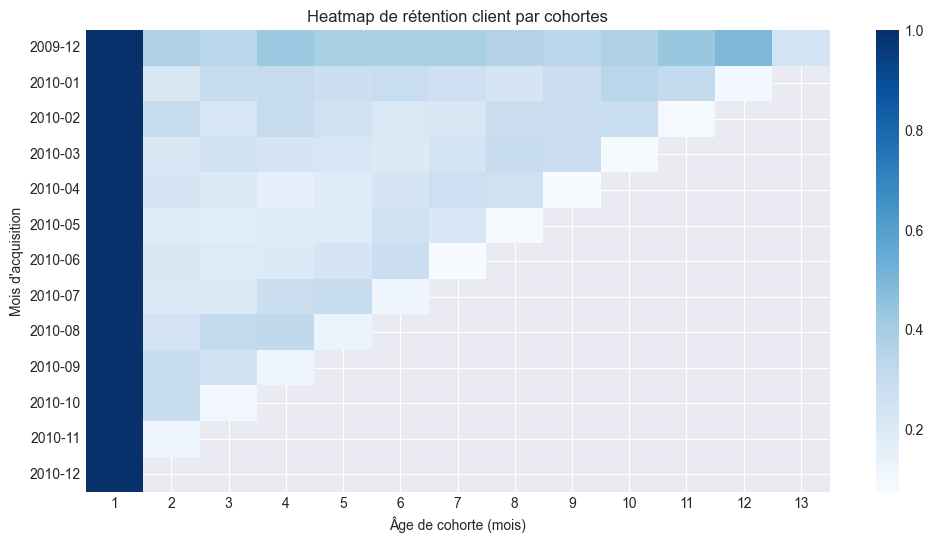

In [31]:
# ======================================================
# COHORTES : Construction & Heatmap de rétention
# ======================================================

# 1. Ajout de la colonne InvoiceMonth (période mensuelle)
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# 2. Mois de première commande du client (cohorte)
cohort_data = (
    df.groupby('Customer ID')['InvoiceMonth']
      .min()
      .rename('CohortMonth')
      .reset_index()
)

df_cohort = df.merge(cohort_data, on='Customer ID')

# 3. Fonction calcul âge cohorte
def cohort_period(row):
    return (
        (row['InvoiceMonth'].year - row['CohortMonth'].year)*12 +
        (row['InvoiceMonth'].month - row['CohortMonth'].month) + 1
    )

df_cohort['CohortIndex'] = df_cohort.apply(cohort_period, axis=1)

# 4. Tableau rétention
cohort_pivot = (
    df_cohort
    .groupby(['CohortMonth', 'CohortIndex'])['Customer ID']
    .nunique()
    .reset_index()
    .pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')
)

# 5. Normalisation (rétention)
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

# 6. Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(retention, cmap='Blues', annot=False, cbar=True)
plt.title("Heatmap de rétention client par cohortes")
plt.xlabel("Âge de cohorte (mois)")
plt.ylabel("Mois d'acquisition")
plt.show()


### Interprétation - Analyse des cohortes

Cette heatmap montre la rétention des clients mois après mois, pour chaque cohorte d’acquisition (mois du premier achat).

#### Points clés observés :

- **La cohorte 2009-12 est la plus solide**, avec une rétention élevée jusqu’à M+8.  
  Cela s'explique probablement par un noyau de clients historiques fidèles.

- **À partir de 2010, les cohortes deviennent plus volatiles** :  
  la majorité des clients décrochent entre **M+2 et M+4**.

- **La forme triangulaire du graphique est normale** :  
  les cohortes récentes ont moins d’historique → elles ne peuvent pas avoir de valeurs au-delà de M+5/M+6.

- Le taux de rétention de M+1 oscille généralement autour de **30%–40%** pour les cohortes 2010.  
  Cela représente un comportement typique des clients e-commerce (effet one-shot important).

#### Ce que cela implique pour la suite :
- Il sera crucial d’analyser **pourquoi les cohortes 2010 chutent plus vite** que celles de 2009-12.
- Cela permettra :  
  - d’estimer la **CLV empirique**  
  - de tester des **scénarios de rétention** dans l’application Streamlit  
  - d’identifier les cohortes plus sensibles aux actions marketing  

Ce diagnostic constitue la base du module “Cohortes & CLV” dans l’application finale.


Aperçu du RFM corrigé :


,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
Customer ID,,,,,,,
12346.0,67,15,-64.68,3,5,1,9
12347.0,3,2,1323.32,5,2,4,11
12348.0,74,1,222.16,2,1,1,4
12349.0,43,4,2646.99,3,4,5,12
12351.0,11,1,300.93,5,1,2,8


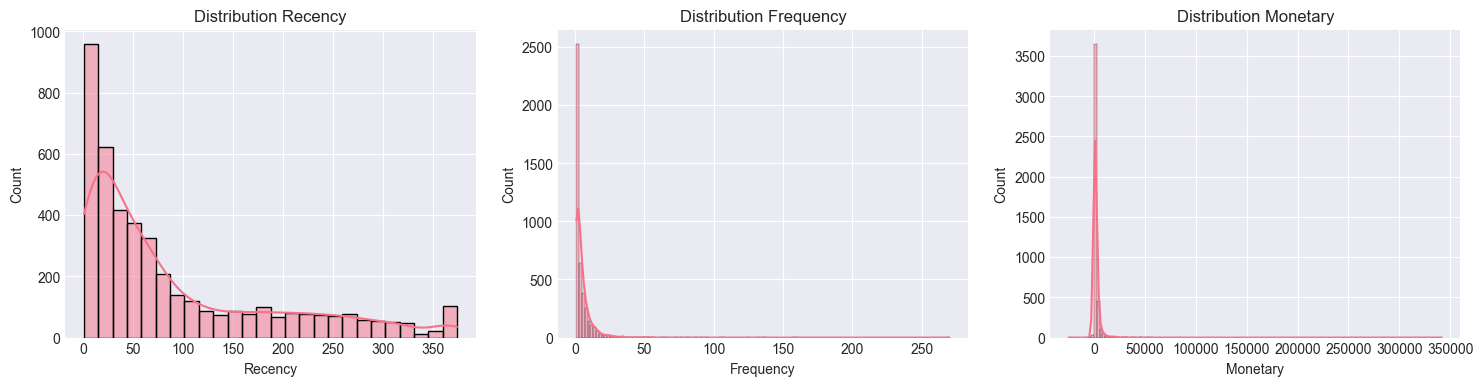

In [33]:
# ======================================================
# ANALYSE RFM (version corrigée)
# ======================================================

# Définition de la date de référence ("snapshot")
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calcul des métriques RFM
rfm = (
    df.groupby('Customer ID')
      .agg({
          'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
          'Invoice': 'nunique',                                    # Frequency
          'Revenue': 'sum'                                         # Monetary
      })
      .rename(columns={
          'InvoiceDate': 'Recency',
          'Invoice': 'Frequency',
          'Revenue': 'Monetary'
      })
)

# ------------------------------------------------------
# R : Recency (quantiles → parfait)
# ------------------------------------------------------
rfm['R_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# ------------------------------------------------------
# F : Frequency (bins fixes → évite l'erreur de qcut)
# ------------------------------------------------------
# Binning intelligent adapté à Online Retail II
rfm['F_rank'] = pd.cut(
    rfm['Frequency'],
    bins=[0, 1, 2, 3, 5, rfm['Frequency'].max()],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True
)

# ------------------------------------------------------
# M : Monetary (quantiles → fonctionne bien)
# ------------------------------------------------------
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')

# Score global
rfm['RFM_Score'] = rfm[['R_rank','F_rank','M_rank']].sum(axis=1)

print("Aperçu du RFM corrigé :")
display(rfm.head())

# Visualisations
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(rfm['Recency'], kde=True, ax=axs[0])
axs[0].set_title("Distribution Recency")

sns.histplot(rfm['Frequency'], kde=True, ax=axs[1])
axs[1].set_title("Distribution Frequency")

sns.histplot(rfm['Monetary'], kde=True, ax=axs[2])
axs[2].set_title("Distribution Monetary")

plt.show()


### Interprétation - Analyse RFM

L’analyse RFM permet de segmenter les clients selon leur comportement d’achat.

#### 1. Recency
- La distribution montre un pic important entre 0 et 50 jours : **beaucoup de clients récents**.
- Une queue étendue jusqu’à plus de 300 jours indique **une part importante de clients inactifs**.
- Cela traduit un modèle classique e-commerce : un mélange de nouveaux clients et de clients dormants.

#### 2. Frequency
- La majorité des clients ont une fréquence de 1 (une seule facture).
- Peu de clients passent plus de 5 commandes.
- Cela confirme que **la base client est dominée par des acheteurs occasionnels**.

#### 3. Monetary
- Beaucoup de petits paniers, quelques clients avec des paniers très élevés (jusqu’à 300k GBP).
- La distribution est très asymétrique : signe de clients “gros comptes”.
- Les valeurs négatives indiquent des **retours importants** (CA négatif pour certains clients).

#### 4. Segmentation RFM
Grâce aux scores R, F et M (1 à 5), nous pouvons identifier :

- **Champions** (score élevé sur R, F et M)  
- **Clients fidèles mais récents** (R faible, F fort, M moyen)
- **Clients à risque** (R élevé, F faible)
- **One-shot buyers** (F=1, M faible)
- **Clients VIP** (F très fort ou M très élevé)

#### Enjeux pour l’application Streamlit :
Ce RFM permettra :
- d’alimenter la page **Segments**,  
- de générer une **liste activable**,  
- de créer des **scénarios de remises ciblées**,
- d’estimer le **CLV par segment**.


## 12. Résumé et prochaines étapes

In [25]:
print("RESUME DE L'EXPLORATION")
print("="*60)
print("\nDonnées nettoyées:")
print(f"  - {len(df):,} transactions valides")
print(f"  - {df['Customer ID'].nunique():,} clients uniques")
print(f"  - {df['StockCode'].nunique():,} produits uniques")
print(f"  - {df['Country'].nunique()} pays")
print(f"  - Revenu total: £{df['Revenue'].sum():,.2f}")
print()
print("Qualité des données:")
print(f"  - Taux de conservation: {len(df)/len(df_raw)*100:.2f}%")
print(f"  - Aucune valeur manquante dans les colonnes critiques")
print()
print("Insights clés:")
print(f"  - Pays dominant: {df.groupby('Country')['Revenue'].sum().idxmax()}")
print(f"  - Période la plus active: {monthly_revenue.loc[monthly_revenue['Revenue'].idxmax(), 'YearMonth']}")
print(f"  - Heure de pointe: {hourly_revenue.idxmax()}h")
print()
print("Prochaines étapes:")
print("  1. Analyse RFM (Recency, Frequency, Monetary)")
print("  2. Segmentation des clients")
print("  3. Calcul de la Customer Lifetime Value (CLV)")
print("  4. Analyse de cohortes")
print("  5. Modèles prédictifs de churn")

RESUME DE L'EXPLORATION

Données nettoyées:
  - 407,664 transactions valides
  - 4,312 clients uniques
  - 4,017 produits uniques
  - 37 pays
  - Revenu total: £8,832,003.27

Qualité des données:
  - Taux de conservation: 77.58%
  - Aucune valeur manquante dans les colonnes critiques

Insights clés:
  - Pays dominant: United Kingdom
  - Période la plus active: 2010-11
  - Heure de pointe: 12h

Prochaines étapes:
  1. Analyse RFM (Recency, Frequency, Monetary)
  2. Segmentation des clients
  3. Calcul de la Customer Lifetime Value (CLV)
  4. Analyse de cohortes
  5. Modèles prédictifs de churn


## 13. Sauvegarde des données nettoyées (optionnel)

In [26]:
# Sauvegarde des données nettoyées pour analyses futures
output_path = '/Users/maximedutertre/Desktop/Ecole/ECE/4eme annee/data-visualisation/projet_final/data/processed/online_retail_clean.csv'

# Créer le dossier processed s'il n'existe pas
from pathlib import Path
Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# Sauvegarde
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"Données nettoyées sauvegardées: {output_path}")
print(f"Taille du fichier: {Path(output_path).stat().st_size / (1024*1024):.2f} MB")

PermissionError: [WinError 5] Accès refusé: '\\Users\\maximedutertre'